In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Get data
df = pd.read_csv("datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")

df.head()

C:\Users\mikbo\AppData\Local\Temp\ipykernel_19276\2598266850.py:2: DtypeWarning: Columns (99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")


,OBJECTID,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,...,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA,STATUS,DATE,LATDD,LONGDD,x,y
0,290899,29,1,1,3,1,00006,0,1,21,...,29,F,6,1755.60,AM,1202,39.776933,-94.793517,-94.793517,39.776933
1,290900,29,10,1,2,1,00036,0,1,25,...,29,F,5,158.08,AM,1202,39.735267,-93.940350,-93.940350,39.735267
2,290901,29,100,1,1,1,00029,0,3,165,...,29,P,4,225.06,AM,303,39.466333,-94.787725,-94.787725,39.466333
3,290902,29,1000,1,2,1,00060,0,6,77,...,29,F,5,1938.44,AM,303,37.124864,-93.226503,-93.226503,37.124864
4,290903,29,10000,1,3,1,00076,0,7,67,...,29,F,5,111.60,AM,1202,36.972156,-92.429808,-92.429808,36.972156


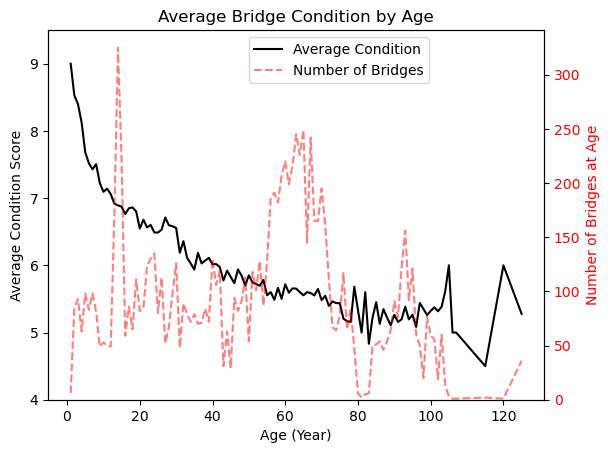

In [ ]:
df_lineplot = pd.DataFrame()  # dataframe used for this specific visualization

# store bridge condition and year built in the dataframe
df_lineplot["Bridge Condition"] = df["LOWEST_RATING"]
df_lineplot["Year Built"] = df["YEAR_BUILT_027"]

# filter out a score of "N" in bridge condition to remove culverts 
df_lineplot["Bridge Condition"] = df_lineplot["Bridge Condition"].apply(lambda x: int(x) if x != "N" else "Culvert")
df_lineplot = df_lineplot[df_lineplot["Bridge Condition"] != "Culvert"]

# get average condition of bridges built in each year, store in df for seaborn usage
avg_condition_list = df_lineplot.groupby("Year Built")["Bridge Condition"].mean()
avg_condition_df = avg_condition_list.reset_index()
avg_condition_df.columns = ["Year Built", "Average Bridge Condition"]

# get number of bridges from each year
bridge_counts = df_lineplot.groupby("Year Built").size().reset_index(name="Bridges Built")
avg_condition_df = avg_condition_df.merge(bridge_counts, on="Year Built")

avg_condition_df["Age"] = 2025 - avg_condition_df["Year Built"] 

# plot using seaborn -- avg bridge score in black, num of bridges in gray
ax = sns.lineplot(data=avg_condition_df, 
                  x="Age", 
                  y="Average Bridge Condition", 
                  color="black", 
                  label="Average Condition")
ax.set_xlabel("Age (Year)")
ax.set_ylim(ymin=4, ymax=9.5)
ax.set_title("Average Bridge Condition by Age")
ax.set_ylabel("Average Condition Score")

ax2 = ax.twinx()
ax2 = sns.lineplot(data=avg_condition_df, 
                   x="Age", 
                   y="Bridges Built", 
                   color="red", 
                   linestyle="--", 
                   alpha =0.5, 
                   label="Number of Bridges")

ax2.set_ylim(ymin=0)
ax2.set_ylabel("Number of Bridges at Age", color="red")
for label in ax2.get_yticklabels():
    label.set_color("red")

# grab labels used for legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# remove autogenerated legends (sometimes overlap with legend to be added)
ax.legend_.remove()
ax2.legend_.remove()

# add legend with labels from both axes
ax.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    bbox_to_anchor=(.39, 1),
)

fig = plt.gcf()
fig.savefig("Average Bridge Condition by Age")

In [18]:
import numpy as np
np.average(avg_condition_df["Age"])

55.8

C:\Users\mikbo\AppData\Local\Temp\ipykernel_19276\3876344621.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Decade Built", y="Bridge Condition", data=df_box, palette="Set3")


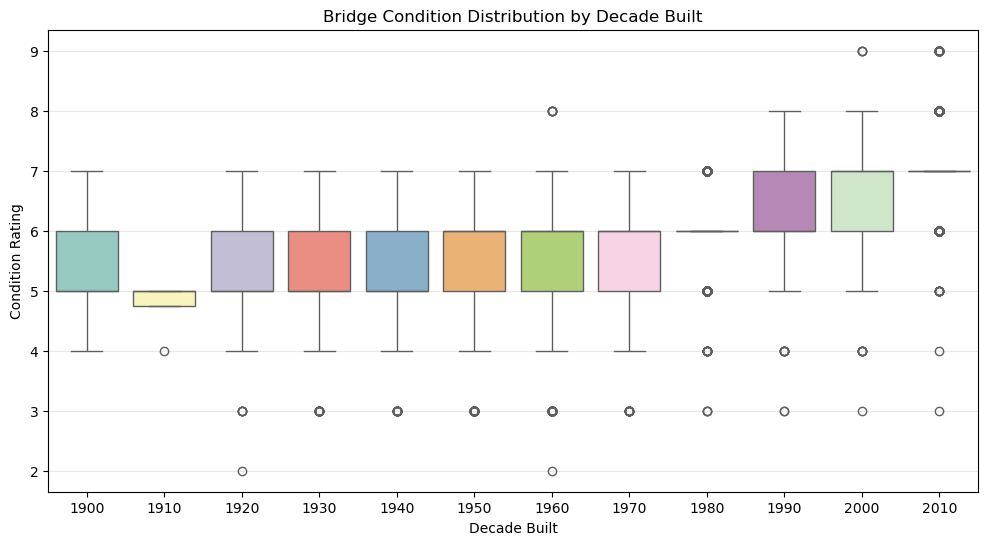

In [19]:
# Box plot of bridge condition by decade 

df_box = pd.DataFrame()

# store bridge condition and year built in the dataframe
df_box["Bridge Condition"] = df["LOWEST_RATING"]
df_box["Year Built"] = df["YEAR_BUILT_027"]

# filter out a score of "N" in bridge condition to remove culverts 
df_box["Bridge Condition"] = df_box["Bridge Condition"].apply(lambda x: int(x) if x != "N" else "Culvert")
df_box = df_box[df_box["Bridge Condition"] != "Culvert"]
df_box.reset_index(inplace=True, drop=True)

# make bridges sortable by decade built
df_box["Decade Built"] = (df_box["Year Built"] // 10) * 10

# remove incomplete decade (not a good visual)
df_box = df_box[df_box["Decade Built"] != 2020]

# create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x="Decade Built", y="Bridge Condition", data=df_box, palette="Set3")

ax.set_title("Bridge Condition Distribution by Decade Built")
ax.set_xlabel("Decade Built")
ax.set_ylabel("Condition Rating")
ax.grid(axis="y", alpha=0.3)

fig = plt.gcf()
fig.savefig("Bridge Condition Distribution")

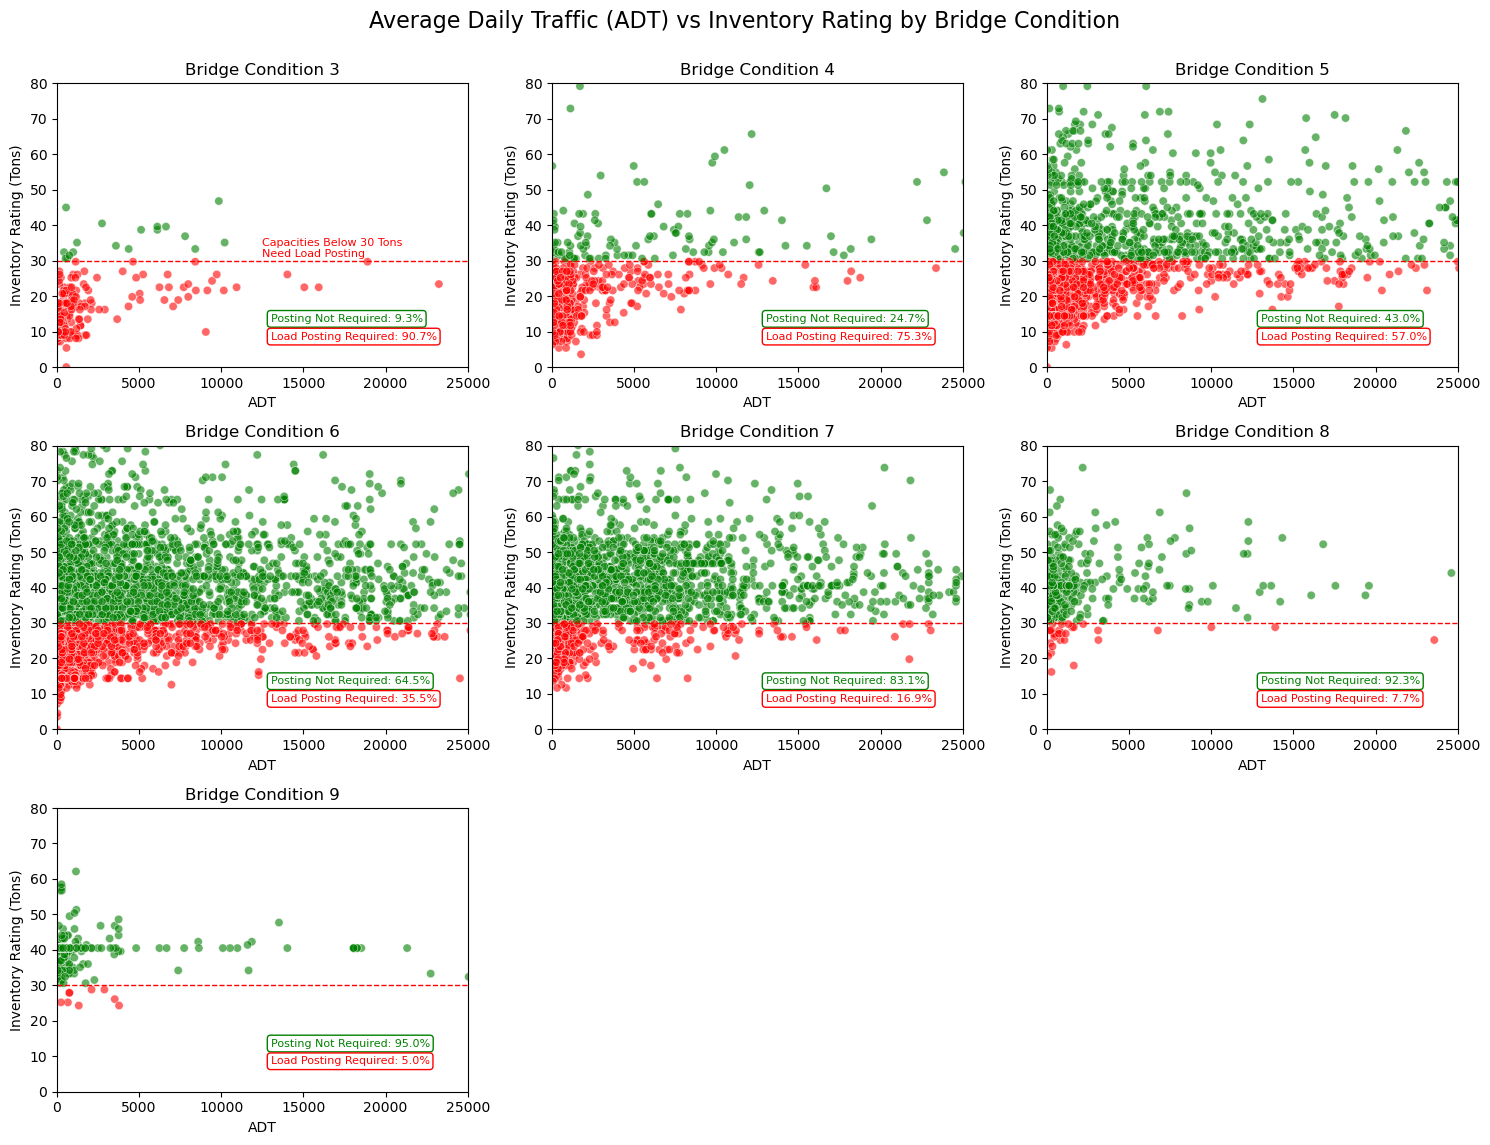

In [37]:
# Scatter -- ADT vs Load rating by condition

df_scatter = pd.DataFrame()

# prepare df for scatter plot with ADT, Bridge Condition, and INV rating
df_scatter["ADT"] = pd.to_numeric(df["ADT_029"], errors="coerce").fillna(0).astype(int)
df_scatter["Bridge Condition"] = df["LOWEST_RATING"]
df_scatter["Inventory Rating"] = pd.to_numeric(df["INVENTORY_RATING_066"], errors="coerce")

# remove culverts
df_scatter["Bridge Condition"] = df_scatter["Bridge Condition"].apply(lambda x: int(x) if x != "N" else "Culvert")
df_scatter = df_scatter[df_scatter["Bridge Condition"] != "Culvert"]
df_scatter.reset_index(inplace=True, drop=True)

# get all conditions excluding 2 (not a significant number of bridges with condition 2)
conditions = range(3, 10)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# set threshold based on load posting standards (EPG 753.15 pg 15-41)
threshold = 30
df_scatter["Below Threshold"] = df_scatter["Inventory Rating"] < threshold

# create scatter plots by condition
for i, condition in enumerate(conditions):
    ax = axes[i]
    data_cond = df_scatter[df_scatter["Bridge Condition"] == condition]
        
    sns.scatterplot(
        ax=ax,
        data=data_cond,
        x="ADT",
        y="Inventory Rating",
        hue="Below Threshold",
        palette={True: "red", False: "green"},
        alpha=0.6,
        legend=False 
    )
    
    ax.set_title(f"Bridge Condition {condition}")
    ax.set_xlim(xmin=0, xmax=25000)
    ax.set_ylim(ymin=0, ymax=80)
    ax.set_xlabel("ADT")
    ax.set_ylabel("Inventory Rating (Tons)")
    ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1)

    # calculate percentages of bridges needing posting
    total = len(data_cond)
    below = (data_cond["Inventory Rating"] < threshold).sum()
    above = total - below

    below_pct = (below / total) * 100 if total > 0 else 0
    above_pct = (above / total) * 100 if total > 0 else 0

    # legend for number of bridges not needing load posting
    ax.text(
        x=13000,
        y=15,
        s=f"Posting Not Required: {above_pct:.1f}%",
        color="green",
        fontsize=8,
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3', lw=1)
    )

    # legend for number of bridges needing load posting
    ax.text(
        x=13000,
        y=10,
        s=f"Load Posting Required: {below_pct:.1f}%",
        color="red",
        fontsize=8,
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3', lw=1)
    )

# annotate first graph to show the load posting threshold
axes[0].text(
    x=12500,
    y=threshold + 1,
    s=f"Capacities Below {threshold} Tons \nNeed Load Posting",
    color="red",
    fontsize=8
)

# remove unused subplots
for j in range(len(conditions), 9):
    fig.delaxes(axes[j])

plt.suptitle("Average Daily Traffic (ADT) vs Inventory Rating by Bridge Condition", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space for the suptitle
plt.show()

fig.savefig("ADT Scatter Plot.png")
